In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 89% 77.0M/86.8M [00:00<00:00, 210MB/s]
100% 86.8M/86.8M [00:00<00:00, 204MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-classification-mri.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization

In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Training',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size=(256,256)
)

Found 2870 files belonging to 4 classes.


In [7]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Testing',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 394 files belonging to 4 classes.


In [8]:
def std_(image,label):
  image = tf.cast(image/256.,tf.float32)
  return image,label

In [9]:
train_ds = train_ds.map(std_)
test_ds = test_ds.map(std_)

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.2],
    fill_mode='nearest'
)

In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_Generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size = (512,512),
    batch_size=32,
    class_mode='categorical'
)

Found 2870 images belonging to 4 classes.


In [14]:
test_Generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size = (512,512),
    batch_size=32,
    class_mode='categorical'
)

Found 394 images belonging to 4 classes.


In [15]:
from keras.applications.vgg16 import VGG16

In [16]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(512,512,3))

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [18]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block4_conv2':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else :
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [19]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(432,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 432)               56623536  
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 71339956 (272.14 MB)
Trainable params: 68424308 (261.02 MB)
Non-trainable params: 2915648 (11.12 MB)
_________________________________________________________________


In [21]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.fit_generator(
    train_Generator,
    steps_per_epoch=2870//32,
    epochs = 10,
    validation_data=test_Generator,
    validation_steps=394//32
)

<ipython-input-23-435e15479eb3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
89/89 [==============================] - 232s 3s/step - loss: 0.6245 - accuracy: 0.7544
Epoch 2/10
89/89 [==============================] - 230s 3s/step - loss: 0.6021 - accuracy: 0.7681
Epoch 3/10
89/89 [==============================] - 227s 3s/step - loss: 0.5377 - accuracy: 0.7893
Epoch 4/10
89/89 [==============================] - 227s 3s/step - loss: 0.4860 - accuracy: 0.8182
Epoch 5/10
89/89 [==============================] - 228s 3s/step - loss: 0.4805 - accuracy: 0.8058
Epoch 6/10
89/89 [==============================] - 227s 3s/step - loss: 0.4454 - accuracy: 0.8302
Epoch 7/10
89/89 [==============================] - 226s 3s/step - loss: 0.4352 - accuracy: 0.8295
Epoch 8/10
89/89 [==============================] - 229s 3s/step - loss: 0.4014 - accuracy: 0.8520
Epoch 9/10
89/89 [==============================] - 232s 3s/step - loss: 0.3823 - accuracy: 0.8576
Epoch 10/10
89/89 [==============================] - 234s 3s/step - loss: 0.3737 - accuracy: 0.8552


In [27]:
import cv2

In [28]:
test_img = cv2.imread('/content/Testing/meningioma_tumor/image(124).jpg')

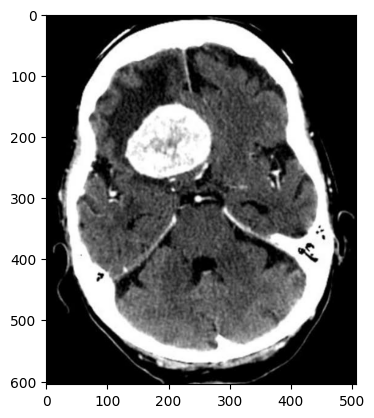

In [29]:
plt.imshow(test_img)

In [30]:
test_img = cv2.resize(test_img,(512,512))

In [31]:
test_input = test_img.reshape((1,512,512,3))

In [32]:
model.predict(test_input)

1/1 [==============================] - 2s 2s/step


array([[0., 1., 0., 0.]], dtype=float32)